<a href="https://colab.research.google.com/github/emredeveloper/Yapay-Zeka-Denemelerim/blob/main/Active_Learning_Gemma_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Active Learning and Gemma 3
# This notebook explores active learning to enhance machine learning models on gold price data,
# with visualization analysis powered by Gemma 3.

# 1. Install Dependencies
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
from PIL import Image
import torch
import gc
from huggingface_hub import login

# Hugging Face Login (Replace with your token)
login(token="YOUR_HUGGING_FACE_TOKEN_HERE")

# 2. Data Loading and Feature Engineering
data = pd.read_csv("goldstock.csv", parse_dates=["Date"])
data = data.drop(columns=["Unnamed: 0"])

def add_features(df):
    df['Price_Change'] = df['Close'].diff()
    df['Daily_Return'] = df['Close'].pct_change()
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['High'] - df['Low']
    for lag in [1, 2, 3]:
        df[f'Lag_{lag}'] = df['Close'].shift(lag)
    df['Volume_Change'] = df['Volume'].pct_change()
    return df.dropna()

data = add_features(data)

# 3. Labeling and Data Splitting
def create_labels(df):
    df['Label'] = np.where(
        df['Close'] > df['Close'].shift(1), 1,
        np.where(df['Close'] < df['Close'].shift(1), 0, 2)
    )
    return df.dropna()

data = create_labels(data)

features = ['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_20',
            'Volatility', 'Lag_1', 'Lag_2', 'Lag_3', 'Volume_Change']
X = data[features]
y = data['Label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_unlabeled, X_test, y_unlabeled, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 4. Overfitting Analysis
def analyze_overfitting(model, X_train, y_train, X_test, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"Train Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}")
    if train_score - test_score > 0.05:
        print("⚠️ Potential Overfitting!")
    return train_score, test_score

# 5. Model Comparison and Active Learning
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True, random_state=42)
}

num_iterations = 15
samples_per_iter = 20
performance_df = pd.DataFrame(columns=['Model', 'Iteration', 'Train_Acc', 'Test_Acc'])

for model_name, model in models.items():
    print(f"\n=== {model_name} Model ===")
    X_current_labeled = X_train.copy()
    y_current_labeled = y_train.copy()
    X_current_unlabeled = X_unlabeled.copy()
    y_current_unlabeled = y_unlabeled.copy()

    for iteration in range(num_iterations):
        model.fit(X_current_labeled, y_current_labeled)
        probas = model.predict_proba(X_current_unlabeled)
        uncertainties = -np.sum(probas * np.log(probas + 1e-10), axis=1)
        selected_indices = np.argsort(uncertainties)[-samples_per_iter:]

        X_new = X_current_unlabeled.iloc[selected_indices]
        y_new = y_current_unlabeled.iloc[selected_indices]
        X_current_labeled = pd.concat([X_current_labeled, X_new], ignore_index=True)
        y_current_labeled = pd.concat([y_current_labeled, y_new], ignore_index=True)
        X_current_unlabeled = X_current_unlabeled.drop(X_new.index)
        y_current_unlabeled = y_current_unlabeled.drop(X_new.index)

        train_acc, test_acc = analyze_overfitting(model, X_current_labeled, y_current_labeled, X_test, y_test)
        performance_df = pd.concat([performance_df, pd.DataFrame([{
            'Model': model_name,
            'Iteration': iteration,
            'Train_Acc': train_acc,
            'Test_Acc': test_acc
        }])], ignore_index=True)

# 6. Visualization
plt.figure(figsize=(14,7))
sns.lineplot(x='Iteration', y='Test_Acc', hue='Model', data=performance_df)
plt.title("Model Performance Comparison")
plt.xlabel("Active Learning Iteration")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.savefig('model_performance.png')
plt.show()

# 7. Memory Cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 8. Visualization Analysis with Gemma 3
model = Gemma3ForConditionalGeneration.from_pretrained("google/gemma-3-4b-it", torch_dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")
model.to("cuda")

image_path = "/kaggle/working/model_performance.png"
image = Image.open(image_path).convert("RGB")
prompt = "<start_of_image> Caption this image"

try:
    inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda")
    generate_ids = model.generate(**inputs, max_new_tokens=200)
    output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print("Generated description:", output)
except Exception as e:
    print(f"An error occurred: {e}")

            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587


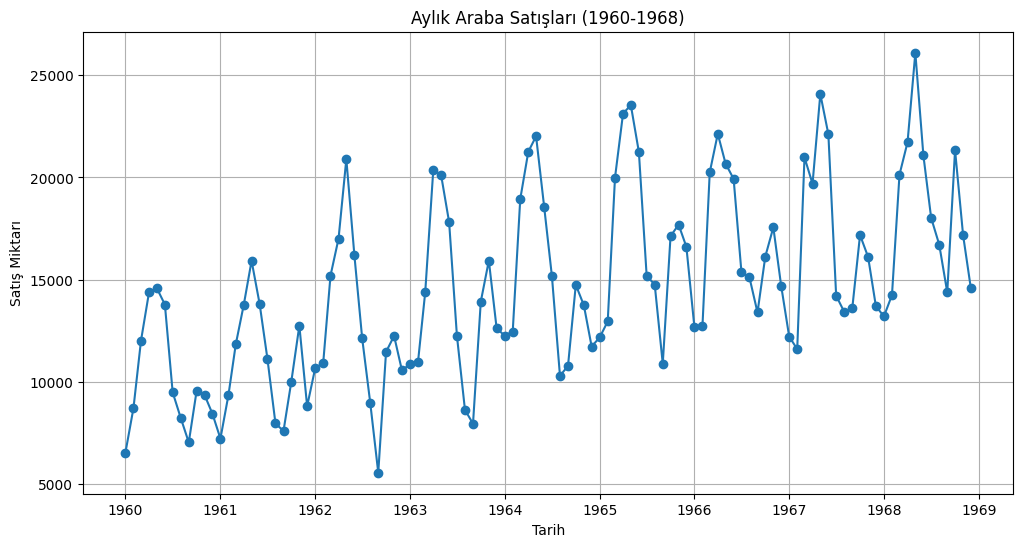

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Veriyi yükle
df = pd.read_csv("monthly-car-sales.csv", parse_dates=["Month"], index_col="Month")
print(df.head())

# Zaman serisini görselleştir
plt.figure(figsize=(12, 6))
plt.plot(df, marker='o', linestyle='-')
plt.title("Aylık Araba Satışları (1960-1968)")
plt.xlabel("Tarih")
plt.ylabel("Satış Miktarı")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Başlangıçta etiketlenmemiş veri
df["Kategori"] = np.nan  # Kategorileri başlangıçta boş bırak

# Rastgele 5 örnek seç ve manuel etiketle (simülasyon)
np.random.seed(42)
initial_samples = df.sample(5)
for idx in initial_samples.index:
    if df.loc[idx, "Sales"] > 20000:
        df.loc[idx, "Kategori"] = "Yüksek"
    elif df.loc[idx, "Sales"] < 10000:
        df.loc[idx, "Kategori"] = "Düşük"
    else:
        df.loc[idx, "Kategori"] = "Orta"

print("Başlangıç Etiketli Veri:")
print(df.dropna(subset=["Kategori"]))

Başlangıç Etiketli Veri:
            Sales Kategori
Month                     
1960-05-01  14587     Orta
1960-11-01   9364    Düşük
1965-03-01  19990     Orta
1966-06-01  19933     Orta
1966-12-01  14720     Orta


<ipython-input-2-1dc913d15704>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Orta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, "Kategori"] = "Orta"


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Active Learning döngüsü
for iteration in range(5):  # 5 iterasyon yapalım
    # Etiketli ve etiketsiz veriyi ayır
    labeled_data = df.dropna(subset=["Kategori"])
    unlabeled_data = df[df["Kategori"].isna()]

    # Modeli eğit
    X_labeled = labeled_data[["Sales"]]
    y_labeled = labeled_data["Kategori"]
    model = RandomForestClassifier(random_state=42)
    model.fit(X_labeled, y_labeled)

    # Etiketsiz veri üzerinde tahmin yap
    probas = model.predict_proba(unlabeled_data[["Sales"]])

    # En belirsiz örnekleri seç (entropiye göre)
    from scipy.stats import entropy
    uncertainties = np.array([entropy(proba) for proba in probas])
    most_uncertain_indices = uncertainties.argsort()[-5:]  # En belirsiz 5 örnek

    # Kullanıcıya bu örnekleri sor (simülasyon)
    for idx in unlabeled_data.iloc[most_uncertain_indices].index:
        print(f"Örnek: Tarih = {idx}, Satış = {df.loc[idx, 'Sales']}")
        # Kullanıcı etiketi girer (simülasyon)
        if df.loc[idx, "Sales"] > 20000:
            df.loc[idx, "Kategori"] = "Yüksek"
        elif df.loc[idx, "Sales"] < 10000:
            df.loc[idx, "Kategori"] = "Düşük"
        else:
            df.loc[idx, "Kategori"] = "Orta"

    # Model performansını değerlendir
    y_pred = model.predict(X_labeled)
    print(f"Iterasyon {iteration + 1} - Sınıflandırma Raporu:")
    print(classification_report(y_labeled, y_pred))

Örnek: Tarih = 1964-08-01 00:00:00, Satış = 10306
Örnek: Tarih = 1963-02-01 00:00:00, Satış = 10965
Örnek: Tarih = 1963-01-01 00:00:00, Satış = 10862
Örnek: Tarih = 1965-09-01 00:00:00, Satış = 10895
Örnek: Tarih = 1967-02-01 00:00:00, Satış = 11608
Iterasyon 1 - Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Düşük       1.00      1.00      1.00         1
        Orta       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Örnek: Tarih = 1961-09-01 00:00:00, Satış = 7610
Örnek: Tarih = 1962-08-01 00:00:00, Satış = 8997
Örnek: Tarih = 1962-09-01 00:00:00, Satış = 5568
Örnek: Tarih = 1963-08-01 00:00:00, Satış = 8642
Örnek: Tarih = 1963-09-01 00:00:00, Satış = 7962
Iterasyon 2 - Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Düşük       1.00      1.00      1.00        

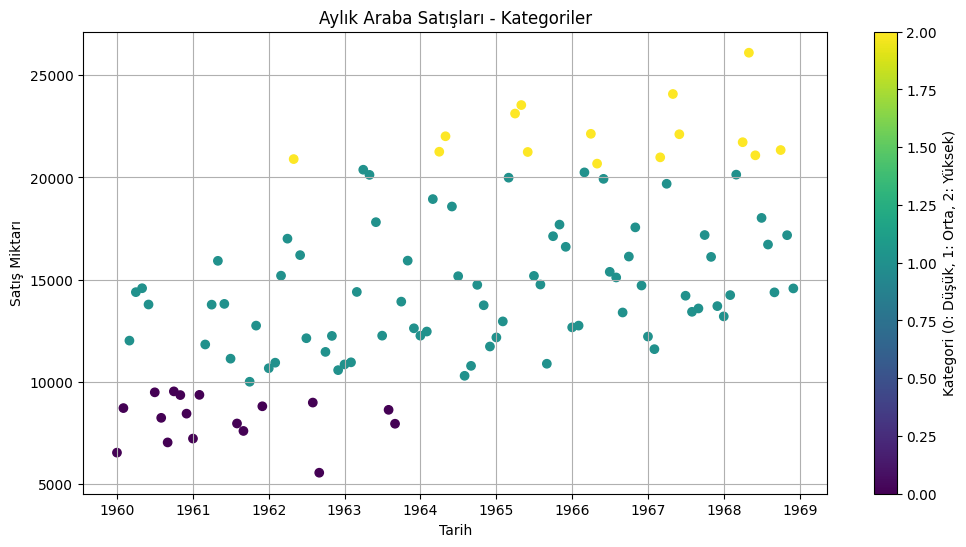

In [ ]:
# Kalan etiketsiz veriyi etiketle
unlabeled_data = df[df["Kategori"].isna()]
df.loc[unlabeled_data.index, "Kategori"] = model.predict(unlabeled_data[["Sales"]])

# Sonuçları görselleştir
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["Sales"], c=df["Kategori"].map({"Düşük": 0, "Orta": 1, "Yüksek": 2}), cmap="viridis")
plt.title("Aylık Araba Satışları - Kategoriler")
plt.xlabel("Tarih")
plt.ylabel("Satış Miktarı")
plt.colorbar(label="Kategori (0: Düşük, 1: Orta, 2: Yüksek)")
plt.grid(True)
plt.show()

In [ ]:
df.to_csv("labeled-monthly-car-sales.csv")